# 2-D Ising Model

We will investigate the 2-d Ising model with Monte Carlo methods. Since there are many internal iterations, it is much faster to run in `C++` with `swig`. 

### Compile with swig

In [1]:
! swig -c++ -python swig/ising.i
! python swig/setup_ising.py build_ext --inplace

running build_ext
building '_ising' extension
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.7m -c swig/ising_wrap.cxx -o build/temp.linux-x86_64-3.7/swig/ising_wrap.o -I./ -std=c++11 -O3
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.7m -c ising.cpp -o build/temp.linux-x86_64-3.7/ising.o -I./ -std=c++11 -O3
x86_64-linux-gnu-g++ -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fstack-protector-strong -Wformat -Werror=format-s

### Import from swig

In [2]:
import sys
import os
sys.path.append( os.path.abspath("swig") )
import ising
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
# Make the plots a bit bigger to see
# NOTE: Must be done in a separate cell
plt.rcParams['figure.dpi'] = 100

## Run the simulations for various temperatures


Also plot the average magnetization as a function of the MC step. 

In [4]:
L = 40
J = 1.0
H = 0.0
MCSteps = 8000

eAvgVals = []
mAvgVals = []
e2AvgVals = []
m2AvgVals = []
i = ising.Ising(J, L, 0.0, 0.0)
Tvals = np.arange(0.01,3.51,0.01)
for T in Tvals:
    i.set_T(T)
    i.compute_boltzmann_factors()
    i.reset_averages()
    i.run(MCSteps)
    mvals = i.get_mvals()
    eAvgVals.append( i.get_eAvg() )
    e2AvgVals.append( i.get_e2Avg() )
    mAvgVals.append( i.get_mAvg() )
    m2AvgVals.append( i.get_m2Avg() )    


### Plot average magnetization versus temperature

In [5]:
def fit_func(T, Tc, b):
    if T <= Tc:
        return (1.0 - (np.sinh(2.0/T))**(-4) )**b
    else:
        return 0.0

def fitfunc_vec_self(T, Tc, b):
    y = np.zeros(T.shape)
    for i in range(len(y)):
        y[i]=fit_func(T[i],Tc,b)
    return y


In [6]:
xvals = Tvals
yvals = np.abs(mAvgVals)
popt, pcov = curve_fit(fitfunc_vec_self, xvals, yvals, bounds=([2.0,0.09], [2.5,0.15]) )
print(r"Estimate for T_c = ", popt[0])
print(r"Estimate for beta = ", popt[1])
plt.scatter(xvals, yvals , c= 'red', s= 4.0, label=r'$\langle M \rangle$')
plt.plot(xvals, fitfunc_vec_self(xvals, *popt), label = 'Fit')
# plt.plot(xvals, fitfunc(xvals, *popt), label = 'Fit')
plt.legend()
plt.xlabel("T")
plt.ylabel(r'$\langle M \rangle$')
# plt.savefig("data/2d/L_40_2d_MvT.pdf")
# plt.show()

### Plot average energy per spin versus Temperature

In [7]:
Eavgval = eAvgVals
plt.scatter(Tvals, Eavgval , c= 'red', s= 1.0, label=r'$\langle E \rangle$')
plt.legend()
plt.xlabel("T")
plt.ylabel(r'$\langle E \rangle$')
# plt.savefig("data/2d/L_40_2d_EvT.pdf")
plt.show()

In [8]:
def find_Der(yvals, xvals):
    ''' f     : name of function to be differentiated
        x     : the point at which df/dx is required
        h     : step size
    '''
    
    nn = len(yvals)
    dfdx = np.zeros(nn)
    #for i in range(2,nn-2):
        #dfdx[i+2] = ( yvals[i-2] - 8*yvals[i-1] + 8*yvals[i+1] - yvals[i+2]) / (12*(xvals[i+1] - xvals[i]) )
    for i in range(0,nn-1):    
        dfdx [i+1] = (yvals[i+1] -yvals[i])/(xvals[i+1] - xvals[i])
    return dfdx


### Specific Heat $C_v = \frac{d\langle E \rangle}{dT}$

In [9]:
dEdT = find_Der(eAvgVals, Tvals)
plt.scatter(Tvals, dEdT , c= 'red', s= 1.0, label = r'$C = \frac{d\langle E \rangle}{dT}$')
#plt.plot(Tvals,dEdT)
plt.legend()
plt.xlabel("T")
plt.ylabel(r'$C = \frac{d\langle E \rangle}{dT}$')
# plt.savefig("data/2d/L_40_2d_CvT.pdf")
plt.show()

### Magnetic susceptibility $\chi = \frac{\langle M^2 \rangle - \langle M \rangle^2}{T}$

In [10]:
chi = (m2AvgVals - np.square(mAvgVals))/Tvals
plt.scatter(Tvals, chi , c= 'red', s= 1.0, label =r'$\chi$')
#plt.plot(Tvals,dEdT)
plt.legend()
plt.xlabel("T")
plt.ylabel(r'$\chi$')
# plt.savefig("data/2d/L_40_2d_ChivT.pdf")
plt.show()

## Run simulation for various Magnetic Field  
We consider $H$ as thermodynamic variable keeping $T$ as constant at $T<T_c$ , $T=T_c$ and $T>T_c$ where the $T_c = 2.3$

In [11]:
L = 40
J = 1.0
# Values of T = 1.0, 2.26, 3.5
T = 1.0
H = -5.0
MCSteps = 8000

eAvgVal = []
mAvgVal = []
# print(spin)
i = ising.Ising(J, L, T, 0.0)
Hvals = np.arange(-0.5,0.5,0.005)
Hvals = np.append(Hvals,Hvals[::-1])
for H in Hvals:
    i.set_H(H)
    i.compute_boltzmann_factors()
    i.reset_averages()
    i.run(MCSteps)
    mvals = i.get_mvals()
    eAvgVal.append( i.get_eAvg() )
    mAvgVal.append( i.get_mAvg() )
#     print(i.get_T(),i.get_H(),i.get_eAvg(),i.get_mAvg() )


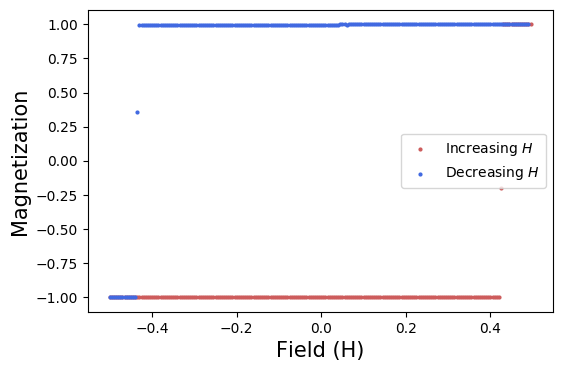

In [32]:
nn = len(Hvals)
# print(nn)
H_up = Hvals[0:int(nn/2)]
M_up = mAvgVal[0:int(nn/2)]
H_dn = Hvals[int(nn/2)+1:nn]
M_dn = mAvgVal[int(nn/2)+1:nn]
plt.scatter(H_up, M_up , c= 'IndianRed', s= 4,marker='o', label='Increasing $H$')
plt.scatter(H_dn, M_dn , c= 'RoyalBlue', s= 4,marker='o', label='Decreasing $H$')
plt.legend()
# plt.xlim(-0.15,0.15)
plt.xlabel("Field (H)", fontsize=15);
plt.ylabel('Magnetization', fontsize=15);         #plt.axis('tight');
# plt.savefig("paperdata/L_40_2d_MvH_T_10.pdf")
# plt.show()

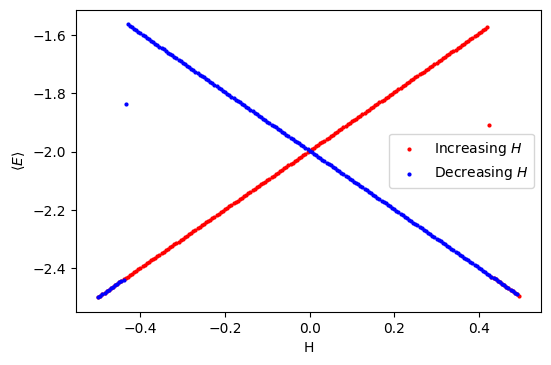

In [13]:
E_up = eAvgVal[0:int(nn/2)]
E_dn = eAvgVal[int(nn/2)+1:nn]
plt.scatter(H_up, E_up , c= 'red', s= 4.0, label='Increasing $H$')
plt.scatter(H_dn, E_dn , c= 'blue', s= 4.0, label='Decreasing $H$')
plt.legend()
# plt.xlim(-0.15,0.15)
plt.xlabel("H")
plt.ylabel(r'$\langle E \rangle$')
# plt.savefig("paperdata/2d/L_40_2d_EvH_T_35.pdf")
plt.show()